In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time

In [2]:
class AP_GRU(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        P = torch.sigmoid(lin_out)
        S = torch.bernoulli(P)
        return S, P



In [3]:
batch_size = 5
batch_length = 50000
H_no = 20
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
#D = V.copy()
D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
D_train = torch.from_numpy(D_train).float()
D_test = torch.from_numpy(D_test).float().to(device)

#D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spk.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
#D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
#D_train = D[:980].float()
#D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

1461


In [ ]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out, batch_P = model(batch_V, batch_D)
    loss = bce_criterion(batch_P, batch_S)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out, P_test = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = bce_criterion(P_test, S_test[:,part_time_idx]).item()
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-321b4365c8b7>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/39200 [00:00<?, ?it/s]

0 0.6340872645378113 0.37604784965515137
49 0.009508124552667141 0.37241673469543457
99 0.005726509261876345 0.5062687397003174
149 0.004959480371326208 0.425339937210083
199 0.004629230592399836 0.478137731552124
249 0.004466642159968615 0.37035679817199707
299 0.0043790871277451515 0.37130165100097656
349 0.004329805728048086 0.37137770652770996
399 0.0043032849207520485 0.37166810035705566
449 0.004287321120500565 0.3696575164794922
499 0.004276724997907877 0.370006799697876
549 0.004267666023224592 0.37082958221435547
599 0.004252763465046883 0.36997246742248535
649 0.00420819828286767 0.37123799324035645
699 0.00410723639652133 0.36964869499206543
749 0.003958052955567837 0.371173620223999
799 0.0036759490612894297 0.374314546585083
849 0.003397780004888773 0.3728632926940918
899 0.003327199025079608 0.37188291549682617
949 0.0032756065484136343 0.37299299240112305
999 0.0032370928674936295 0.3731253147125244
1049 0.003210380207747221 0.36943626403808594
1099 0.0031808922067284584

In [7]:
# 2649 0.004261615686118603 (true_na with refractory)
# 31249 0.0029351413249969482  (true_na without refractory)
# 35499 0.0030055860988795757  (comb_pred without refractory)
# 29749 0.003061493393033743  (whole_pred without refractory)


# AP True
# 0.00019483866344671696 (V, D)
# 0.0006420775316655636 (V only)

# Na True
# 0.0012602820061147213 (V, D)
# 0.0018874892266467214 (V only)

# No Na True
# 0.0013189633609727025 (V, D)
# 0.0018882722361013293 (V only)

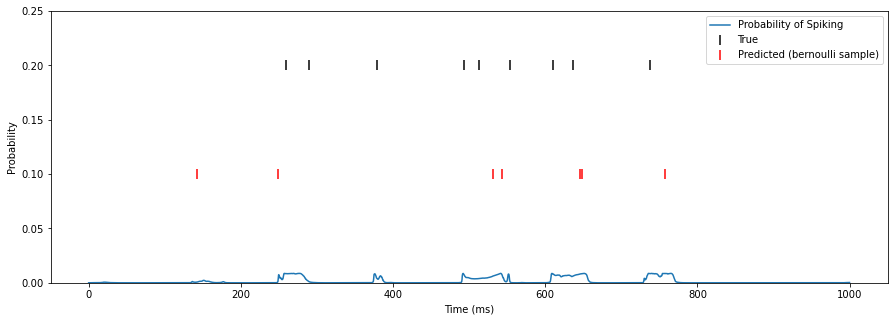

In [7]:
plt.figure(figsize = (15,5))
plt.plot(np.arange(0,1000,0.2), P_test[0][10000:15000].cpu().detach().numpy()[:], label="Probability of Spiking")
plt.scatter(np.arange(0,1000,0.2), S_test[0][12000:32000][10000:15000].cpu().detach().numpy()-0.8, s=100, color="black", marker="|", label="True")
plt.scatter(np.arange(0,1000,0.2), test_S_out[0][10000:15000].cpu().detach().numpy()*0.9-0.8, s=100, color="red", marker="|", label="Predicted (bernoulli sample)")
plt.ylim(0,0.25)
plt.xlabel("Time (ms)")
plt.ylabel("Probability")
plt.legend()